In [27]:
import pandas as pd
data = pd.read_parquet('/Users/markshevchenkopu/BXL-Bouman-7/projects/08-DS-recruitment-challenge/transactions.parquet', engine='fastparquet')

In [28]:
data.head()

,Shop,Order_Date_FK,ProductCode,OriginalSaleAmountInclVAT,CustomerID,SaleDocumentNumber,Returned,RevenueInclVAT,CostPriceExclVAT,BrandName,ModelGroup,ProductGroup
0,36,20210730,-1968361059464632550,99.95,-2190786785520839526,23995792,0,74.96,36.534515,3694837121284491212,3162564956579801398,-453682476182549203
1,58,20210730,-1745497788861904687,21.95,-3499949798555834600,23995794,0,21.95,7.364523,-1657270726128381662,-6715310361529623819,-453682476182549203
2,49,20210730,-4482110002029860032,69.95,-7841417233849937172,23995797,0,38.47,24.415000,-7202472198306336051,-248459121805647149,5294166889150293396
3,49,20210730,-9146072753857637799,99.95,-7841417233849937172,23995797,0,54.97,32.293506,-2074012670196538378,-248459121805647149,5294166889150293396
4,15,20210730,-8829485741699345914,49.95,7033964597104594686,23995798,0,17.48,8.885632,-4869459690934553786,-4124706989267335995,-453682476182549203


In [29]:
data.shape

(1759889, 12)

In [30]:
data.isnull().sum()

Shop                         0
Order_Date_FK                0
ProductCode                  0
OriginalSaleAmountInclVAT    0
CustomerID                   0
SaleDocumentNumber           0
Returned                     0
RevenueInclVAT               0
CostPriceExclVAT             0
BrandName                    0
ModelGroup                   0
ProductGroup                 0
dtype: int64

In [31]:
import sqlite3 as sql
con = sql.connect('data.db')
data.to_sql('data', con, if_exists= 'replace', index=False)
connection = sql.connect('data.db')

data.shape


(1759889, 12)

In [32]:
import pandas as pd
pd.read_sql_query('''WITH ahh AS (SELECT COUNT(*) AS count_returned
                  FROM data
                  WHERE Returned = 1), 

                  ahh2 AS (SELECT COUNT(*) AS count_not_returned
                  FROM data
                  WHERE Returned = 0)
                  
                  SELECT count_returned, count_not_returned
                  FROM ahh, ahh2    '''
                  , connection)

,count_returned,count_not_returned
0,67795,1692094


In [33]:
from sklearn.utils import resample

df_1 = data[data['Returned'] == 1]
other_df = data[data['Returned'] == 0]  


df_other_oversampled_training = resample(other_df, n_samples=900000, random_state=42)

# Concatenate the undersampled majority class with the minority class
df_balanced = pd.concat([df_1, df_other_oversampled_training])

# Shuffle the concatenated DataFrame to randomize the order of samples
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


columns_to_keep = ['RevenueInclVAT', 'Returned', 'CostPriceExclVAT', 'OriginalSaleAmountInclVAT']

# Select columns to convert to categorical by removing columns to keep
columns_to_convert = df_balanced.columns.difference(columns_to_keep)

# Convert specified columns to categorical data type
df_balanced[columns_to_convert] = df_balanced[columns_to_convert].astype('category')


df_balanced.dtypes



Shop                         category
Order_Date_FK                category
ProductCode                  category
OriginalSaleAmountInclVAT     float64
CustomerID                   category
SaleDocumentNumber           category
Returned                        int64
RevenueInclVAT                float64
CostPriceExclVAT              float64
BrandName                    category
ModelGroup                   category
ProductGroup                 category
dtype: object

In [34]:

con = sql.connect('df_balanced.db')
df_balanced.to_sql('df_balanced', con, if_exists= 'replace', index=False)
connection = sql.connect('df_balanced.db')

df_balanced = pd.read_sql_query('''
WITH q_user AS (
    SELECT CustomerID, COUNT(SaleDocumentNumber) AS q_per_user
    FROM df_balanced
    GROUP BY CustomerID
),
q_invoice AS (
    SELECT CustomerID, SaleDocumentNumber, COUNT(SaleDocumentNumber) AS q_per_invoice
    FROM df_balanced
    GROUP BY SaleDocumentNumber
), combined AS (
                  SELECT q_user.CustomerID, q_user.q_per_user, q_invoice.SaleDocumentNumber, q_invoice.q_per_invoice
                  FROM q_user
                  JOIN q_invoice
                  ON q_invoice.CustomerID = q_user.CustomerID)
SELECT q_per_user, q_per_invoice, df_balanced.*
FROM combined
JOIN df_balanced
ON combined.CustomerID = df_balanced.CustomerID and combined.SaleDocumentNumber = df_balanced.SaleDocumentNumber
                  

                  ''', connection)



In [35]:
df_balanced.dtypes

q_per_user                     int64
q_per_invoice                  int64
Shop                          object
Order_Date_FK                 object
ProductCode                   object
OriginalSaleAmountInclVAT    float64
CustomerID                    object
SaleDocumentNumber            object
Returned                       int64
RevenueInclVAT               float64
CostPriceExclVAT             float64
BrandName                     object
ModelGroup                    object
ProductGroup                  object
dtype: object

In [36]:
# import xgboost as xgb
# from sklearn.model_selection import RandomizedSearchCV


# # Enable categorical support in XGBoost
# xgb_params = {
#     'enable_categorical': True
# }


# # Define parameters for RandomizedSearchCV
# params = {
#     "learning_rate": [0.20],
#     "max_depth": [ 15],
#     "min_child_weight": [5],
#     "gamma": [0.4],
#     "colsample_bytree": [0.5]
# }

# # Initialize XGBoost model
# my_model = xgb.XGBClassifier(**xgb_params)

# # Initialize RandomizedSearchCV
# rs_model = RandomizedSearchCV(
#     my_model,
#     param_distributions=params,
#     n_iter=3,
#     scoring='roc_auc',
#     n_jobs=-1,
#     cv=5,
#     verbose=3
# )
# X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop(['Returned'], axis=1), df_balanced.Returned, test_size=0.25)
# # Fit the model
# rs_model.fit(X_train, y_train)


In [37]:
df_balanced

,q_per_user,q_per_invoice,Shop,Order_Date_FK,ProductCode,OriginalSaleAmountInclVAT,CustomerID,SaleDocumentNumber,Returned,RevenueInclVAT,CostPriceExclVAT,BrandName,ModelGroup,ProductGroup
0,4,4,25,20210611,-6695580755828751834,39.95,-1000164750628321278,23553042,0,30.92,9.400908,-8846961206607438497,3162564956579801398,-453682476182549203
1,4,4,25,20210611,-6695580755828751834,39.95,-1000164750628321278,23553042,0,30.92,9.400908,-8846961206607438497,3162564956579801398,-453682476182549203
2,4,4,25,20210611,2891829732424645624,49.95,-1000164750628321278,23553042,0,43.50,13.186801,6988179278806901179,-4124706989267335995,-453682476182549203
3,4,4,25,20210611,2891829732424645624,49.95,-1000164750628321278,23553042,0,43.50,13.186801,6988179278806901179,-4124706989267335995,-453682476182549203
4,1,1,24,20210722,3656410683946341740,75.95,-1000296644929864045,23927261,0,60.76,30.001019,8855638714846779199,3162564956579801398,-453682476182549203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967790,14,3,37,20210727,-638888476693673200,39.95,999969001027685779,23966473,0,39.95,16.150000,-4087396388609311917,-4124706989267335995,-453682476182549203
967791,14,3,37,20210727,-638888476693673200,39.95,999969001027685779,23966473,0,39.95,16.150000,-4087396388609311917,-4124706989267335995,-453682476182549203
967792,14,3,37,20210727,-638888476693673200,39.95,999969001027685779,23966473,0,39.95,16.150000,-4087396388609311917,-4124706989267335995,-453682476182549203
967793,2,2,52,20210708,-5991895624078471793,135.00,999971605751475906,23801410,0,67.50,50.400000,7710616350878026677,-248459121805647149,5294166889150293396


In [38]:
df_balanced = df_balanced.drop(columns=['q_per_user','Order_Date_FK', 'SaleDocumentNumber'])


In [39]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Shop', 'ProductCode', 'CustomerID', 'BrandName', 'ModelGroup', 'ProductGroup']

# Initialize LabelEncoders for each categorical column
label_encoders = {}
for col in categorical_columns:
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(df_balanced[col])
    df_balanced[col] = label_encoder.transform(df_balanced[col])
    label_encoders[col] = label_encoder


df_balanced


,q_per_invoice,Shop,ProductCode,OriginalSaleAmountInclVAT,CustomerID,Returned,RevenueInclVAT,CostPriceExclVAT,BrandName,ModelGroup,ProductGroup
0,4,18,7721,39.95,0,0,30.92,9.400908,280,23,0
1,4,18,7721,39.95,0,0,30.92,9.400908,280,23,0
2,4,18,13900,49.95,0,0,43.50,13.186801,523,11,0
3,4,18,13900,49.95,0,0,43.50,13.186801,523,11,0
4,1,17,14894,75.95,1,0,60.76,30.001019,596,23,0
...,...,...,...,...,...,...,...,...,...,...,...
967790,3,31,7349,39.95,278852,0,39.95,16.150000,107,11,0
967791,3,31,7349,39.95,278852,0,39.95,16.150000,107,11,0
967792,3,31,7349,39.95,278852,0,39.95,16.150000,107,11,0
967793,2,46,6807,135.00,278853,0,67.50,50.400000,550,5,3


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Assuming df_balanced is your DataFrame

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop(['Returned'], axis=1), df_balanced['Returned'], test_size=0.25)

# Define XGBoost model parameters
params = {
    "learning_rate": 0.20,
    "max_depth": 15,
    "min_child_weight": 5,
    "gamma": 0.4,
    "colsample_bytree": 0.5
}

# Initialize and train XGBoost model
# Initialize and train XGBoost model
my_model = XGBClassifier(**params)
my_model.fit(X_train, y_train, verbose=False)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
df_balanced.dtypes

q_per_invoice                  int64
Shop                           int64
ProductCode                    int64
OriginalSaleAmountInclVAT    float64
CustomerID                     int64
Returned                       int64
RevenueInclVAT               float64
CostPriceExclVAT             float64
BrandName                      int64
ModelGroup                     int64
ProductGroup                   int64
dtype: object

In [42]:
import joblib

artifacts = {
    "model": my_model
}
joblib.dump(artifacts, "model/artifacts.joblib", compress=3)

for col, encoder in label_encoders.items():
    joblib.dump(encoder, f'model/{col}_label_encoder.joblib')


In [43]:
label_encoders

{'Shop': LabelEncoder(),
 'ProductCode': LabelEncoder(),
 'CustomerID': LabelEncoder(),
 'BrandName': LabelEncoder(),
 'ModelGroup': LabelEncoder(),
 'ProductGroup': LabelEncoder()}

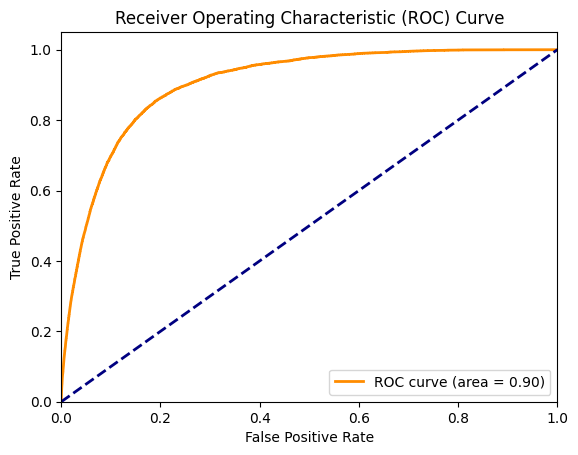

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming model is your trained classifier and X_test is your test data
y_score = my_model.predict_proba(X_test)[:,-1]
 # Probability of positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


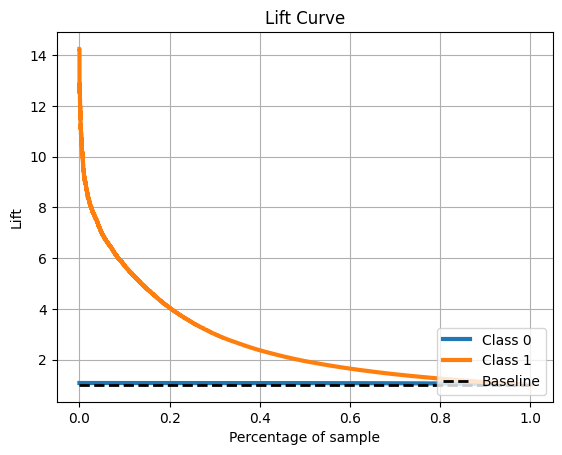

In [45]:
import matplotlib.pyplot as plt

# Import the scikitplot module
import scikitplot as skplt
y_score = my_model.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_score)
plt.show()


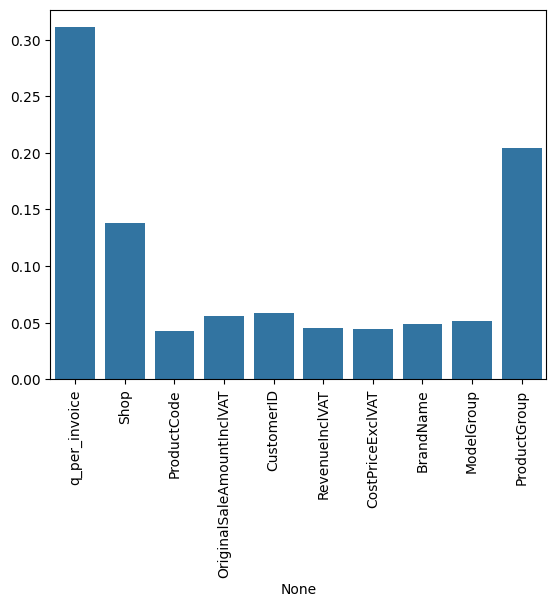

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_importance = my_model.feature_importances_

sns.barplot(x=X_test.columns, y=feature_importance)
plt.xticks(rotation=90)
plt.show()

In [52]:
X_test

,q_per_invoice,Shop,ProductCode,OriginalSaleAmountInclVAT,CustomerID,RevenueInclVAT,CostPriceExclVAT,BrandName,ModelGroup,ProductGroup
831977,3,24,3582,7.50,239425,7.50,1.936446,281,28,4
246634,3,4,21968,25.95,72073,25.95,9.193199,9,23,0
260991,1,2,15543,75.95,72073,68.36,27.104316,73,11,0
67618,2,55,10715,49.95,19373,32.47,8.885632,144,11,0
963199,1,41,1645,79.95,277294,79.95,36.079605,25,11,0
...,...,...,...,...,...,...,...,...,...,...
467090,2,49,14680,25.95,130030,25.95,11.250000,25,13,0
851354,2,71,19606,49.95,245764,49.95,16.742351,321,0,0
773050,2,44,2629,49.95,221904,49.95,18.882491,521,23,0
500904,3,81,11295,7.95,140602,7.95,1.799847,128,29,1


In [47]:
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, recall_score, precision_score
score = my_model.score(X_test, y_test)
predictions = my_model.predict(X_test)
mae = mean_absolute_error(predictions, y_test)
f1 = f1_score(predictions, y_test)
accuracy = accuracy_score(predictions, y_test)
recall = recall_score(predictions, y_test)
precision = precision_score(predictions, y_test)

print("Model Score:", score)
print("Mean Absolute Error:", mae)
print("F1 Score:", f1)
print("Accuracy Score:", accuracy)
print("Recall Score:", recall)
print('Precision Score:', precision)


Model Score: 0.9333165253834486
Mean Absolute Error: 0.06668347461655143
F1 Score: 0.22921842155551309
Accuracy Score: 0.9333165253834486
Recall Score: 0.6078033949835318
Precision Score: 0.14124227259346483


In [48]:
X_test.dtypes

q_per_invoice                  int64
Shop                           int64
ProductCode                    int64
OriginalSaleAmountInclVAT    float64
CustomerID                     int64
RevenueInclVAT               float64
CostPriceExclVAT             float64
BrandName                      int64
ModelGroup                     int64
ProductGroup                   int64
dtype: object

In [49]:
con = sql.connect('df_final.db')

df_balanced.to_sql('df_final', con, if_exists= 'replace', index=False)
connection = sql.connect('df_final.db')

In [50]:
pd.read_sql_query('''SELECT q_per_invoice, COUNT(Returned) AS count_return
                   FROM df_final
                  WHERE Returned = 1
                  GROUP BY q_per_invoice
                  ORDER BY count_return DESC''', connection)

,q_per_invoice,count_return
0,2,29759
1,1,11643
2,4,8927
3,3,7607
4,5,3407
5,6,2728
6,7,1152
7,8,1121
8,9,489
9,10,384


In [51]:
pd.read_sql_query('''SELECT q_per_user, COUNT(Returned) AS count_return
                   FROM df_final
                  WHERE Returned = 1
                  GROUP BY q_per_user
                  ORDER BY count_return DESC''', connection)

DatabaseError: Execution failed on sql 'SELECT q_per_user, COUNT(Returned) AS count_return
                   FROM df_final
                  WHERE Returned = 1
                  GROUP BY q_per_user
                  ORDER BY count_return DESC': no such column: q_per_user

In [ ]:
import sqlite3 as sql
data = data.drop_duplicates()

con = sql.connect('data.db')

data.to_sql('data', con, if_exists= 'replace', index=False)
connection = sql.connect('data.db')

pd.read_sql_query(''' Select Shop, count(*) as count_returned
                  from data
                  where Returned = 1
                  group by Shop
                  order by count_returned DESC''', connection)

,Shop,count_returned
0,102,25176
1,103,1424
2,9,501
3,68,423
4,30,417
...,...,...
79,14,116
80,27,66
81,35,24
82,38,17


In [ ]:
pd.read_sql_query(''' SELECT CustomerID, COUNT(SaleDocumentNumber) AS count_returned
                  FROM data
                  GROUP BY CustomerID
                  Order by count_returned DESC''', connection)

,CustomerID,count_returned
0,-5287955982418449235,43711
1,-4279123115125507326,7780
2,4572026730515361595,3739
3,6455628090489614628,3459
4,1727613839816903509,3399
...,...,...
347857,-9222743193052962658,1
347858,-9222795461272230323,1
347859,-9222861071832643710,1
347860,-9222911225091692607,1


In [ ]:
pd.read_sql_query(''' SELECT ProductCode, COUNT(SaleDocumentNumber) AS count_returned
                  FROM data
                  GROUP BY ProductCode
                  Order by count_returned DESC''', connection)

,ProductCode,count_returned
0,-8705147095127043671,7592
1,3036892314180591217,4262
2,-1078666667586201956,3816
3,-3593338250327416342,3681
4,8244425463214499805,1964
...,...,...
25941,-9209877538612586378,1
25942,-9219501801730801710,1
25943,-9219892727203914272,1
25944,-9220663666743060002,1


In [ ]:
pd.read_sql_query(''' SELECT BrandName, COUNT(SaleDocumentNumber) AS count_returned
                  FROM data
                  GROUP BY BrandName
                  Order by count_returned DESC''', connection)

,BrandName,count_returned
0,-1671135878886367730,59811
1,-4445228402666777776,53990
2,3694837121284491212,51588
3,-8892132782483441489,43779
4,2163194981545980604,39702
...,...,...
644,-7244046429025905887,1
645,-7843948678814522975,1
646,-8093519676797838569,1
647,-8334110515734058988,1


In [ ]:

pd.read_sql_query(''' SELECT ProductCode, CostPriceExclVAT, COUNT(SaleDocumentNumber) AS count_returned
                  FROM data
                  GROUP BY ProductCode
                  ORDER BY count_returned DESC''', connection)


,ProductCode,CostPriceExclVAT,count_returned
0,-8705147095127043671,2.775214,7592
1,3036892314180591217,2.812972,4262
2,-1078666667586201956,3.823463,3816
3,-3593338250327416342,1.965903,3681
4,8244425463214499805,2.383941,1964
...,...,...,...
25941,-9209877538612586378,16.916457,1
25942,-9219501801730801710,59.000000,1
25943,-9219892727203914272,38.000000,1
25944,-9220663666743060002,27.302143,1


In [ ]:
pd.read_sql_query(''' SELECT CostPriceExclVAT, COUNT(SaleDocumentNumber) AS count_returned
                  FROM data
                  GROUP BY CostPriceExclVAT
                  ORDER BY CostPriceExclVAT DESC''', connection)
                  

,CostPriceExclVAT,count_returned
0,1064.250000,27
1,480.284214,1
2,105.632817,1
3,101.303306,1
4,100.568660,1
...,...,...
19229,-4.177193,5
19230,-4.453833,3
19231,-7.918922,4
19232,-10.982706,3


In [ ]:
# Define your SQL query
pd.read_sql_query('''
WITH sales AS (
    SELECT Shop, SUM(OriginalSaleAmountInclVAT) as sum 
    FROM data
    WHERE Returned = 1
    GROUP BY Shop
),
purchases AS (
    SELECT Shop, SUM(OriginalSaleAmountInclVAT) as sum 
    FROM data
    GROUP BY Shop
)

SELECT sales.Shop, sales.sum as total_return_sales, purchases.sum as total_purchases, sales.sum / purchases.sum as return_rate
FROM sales
JOIN purchases ON sales.Shop = purchases.Shop
ORDER BY return_rate DESC
''', connection)


,Shop,total_return_sales,total_purchases,return_rate
0,102,1877864.02,9852314.20,0.190601
1,103,112724.32,677793.57,0.166311
2,41,423.60,6981.37,0.060676
3,30,25226.53,599431.28,0.042084
4,68,25338.15,696668.29,0.036370
...,...,...,...,...
79,58,12323.58,683292.73,0.018036
80,48,13247.90,752974.43,0.017594
81,54,6567.33,389196.19,0.016874
82,35,1308.77,82218.91,0.015918


In [ ]:
pd.read_sql_query('''
        SELECT 
        COUNT(DISTINCT Shop) AS shop_count, 
        COUNT(DISTINCT CustomerID) AS unique_customers, 
        COUNT(DISTINCT ProductCode) AS unique_items 
    FROM 
        data''', connection)

,shop_count,unique_customers,unique_items
0,85,347862,25946
